In [1]:
!pip install pandas numpy matplotlib skit-learn fpdf

ERROR: Could not find a version that satisfies the requirement skit-learn (from versions: none)
ERROR: No matching distribution found for skit-learn

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd

# Load dataset
df = pd.read_csv("C:/Users/mylav/Downloads/archive (8)/GlobalWeatherRepository.csv")

# Preview the data
df.head()


,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [4]:
# Remove columns with over 50% missing values
threshold = len(df) * 0.5
df_cleaned = df.dropna(axis=1, thresh=threshold)

# Fill missing values
for column in df_cleaned.columns:
    if df_cleaned[column].dtype in ['float64', 'int64']:
        df_cleaned[column].fillna(df_cleaned[column].median(), inplace=True)
    else:
        df_cleaned[column].fillna(df_cleaned[column].mode()[0], inplace=True)


C:\Users\mylav\AppData\Local\Temp\ipykernel_6516\2519199224.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[column].fillna(df_cleaned[column].mode()[0], inplace=True)
C:\Users\mylav\AppData\Local\Temp\ipykernel_6516\2519199224.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [6]:
# Select only numeric columns
numeric_df = df_cleaned.select_dtypes(include=['float64', 'int64'])

# Compute Q1 and Q3 for numeric data only
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Remove outliers using IQR (only for numeric data)
df_cleaned = df_cleaned[~((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)]


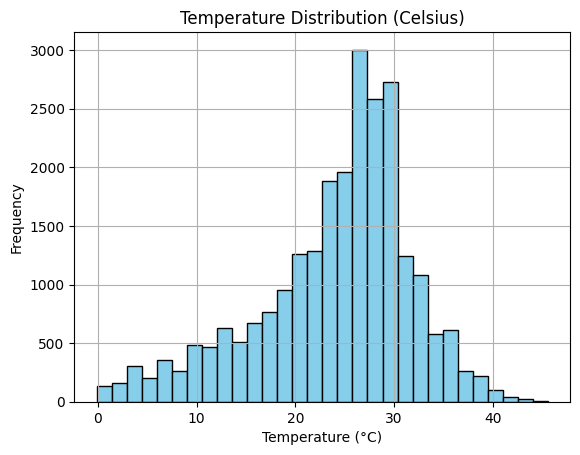

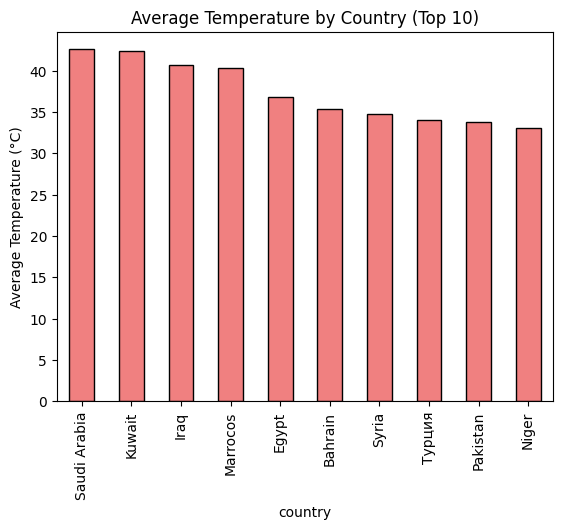

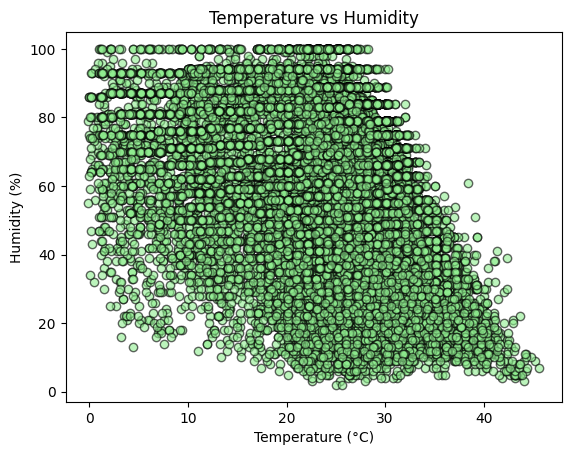

In [7]:
import matplotlib.pyplot as plt

df_cleaned['temperature_celsius'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Temperature Distribution (Celsius)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()

top_countries = df_cleaned.groupby('country')['temperature_celsius'].mean().nlargest(10)
top_countries.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Average Temperature by Country (Top 10)')
plt.ylabel('Average Temperature (°C)')
plt.show()

plt.scatter(df_cleaned['temperature_celsius'], df_cleaned['humidity'], color='lightgreen', alpha=0.6, edgecolors='black')
plt.title('Temperature vs Humidity')
plt.xlabel('Temperature (°C)')
plt.ylabel('Humidity (%)')
plt.show()



C:\Users\mylav\AppData\Local\Temp\ipykernel_6516\149502695.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['anomaly'] = model.fit_predict(df_cleaned[['temperature_celsius', 'humidity']])


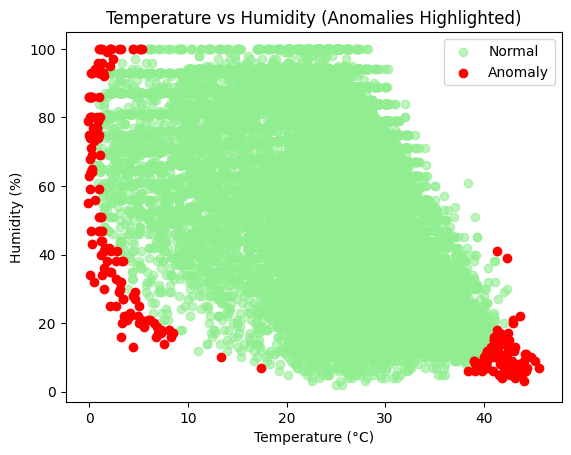

In [8]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df_cleaned['anomaly'] = model.fit_predict(df_cleaned[['temperature_celsius', 'humidity']])

# Separate anomalies and normal points
normal_data = df_cleaned[df_cleaned['anomaly'] == 1]
anomalies = df_cleaned[df_cleaned['anomaly'] == -1]

# Plot anomalies
plt.scatter(normal_data['temperature_celsius'], normal_data['humidity'], color='lightgreen', label='Normal', alpha=0.6)
plt.scatter(anomalies['temperature_celsius'], anomalies['humidity'], color='red', label='Anomaly')
plt.title('Temperature vs Humidity (Anomalies Highlighted)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Humidity (%)')
plt.legend()
plt.show()


In [20]:
# Clean column names
df_cleaned.columns = df_cleaned.columns.str.strip().str.lower()

# Check if 'last_updated' column exists
if 'last_updated' in df_cleaned.columns:
    df_cleaned['last_updated'] = pd.to_datetime(df_cleaned['last_updated'])
    df_cleaned.set_index('last_updated', inplace=True)
else:
    print("Column 'last_updated' not found!")

# Proceed only if 'last_updated' exists
if 'last_updated' in df_cleaned.columns:
    X = df_cleaned[['humidity', 'pressure_mb', 'wind_kph']]
    y = df_cleaned['temperature_celsius']

    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
else:
    print("Cannot proceed - 'last_updated' column is missing.")


Column 'last_updated' not found!
Cannot proceed - 'last_updated' column is missing.


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

rf_rmse = mean_squared_error(y_test, rf_preds, squared=False)
rf_r2 = r2_score(y_test, rf_preds)

print(f"RF RMSE: {rf_rmse}, RF R2: {rf_r2}")


RF RMSE: 7.300323562191345, RF R2: 0.28865951164017745


c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)

gb_rmse = mean_squared_error(y_test, gb_preds, squared=False)
gb_r2 = r2_score(y_test, gb_preds)

print(f"GB RMSE: {gb_rmse}, GB R2: {gb_r2}")


GB RMSE: 7.173990548787796, GB R2: 0.3130661608356584


c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [23]:
from sklearn.ensemble import StackingRegressor

ensemble = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ],
    final_estimator=GradientBoostingRegressor(n_estimators=100, random_state=42)
)

ensemble.fit(X_train, y_train)
ensemble_preds = ensemble.predict(X_test)

ensemble_rmse = mean_squared_error(y_test, ensemble_preds, squared=False)
ensemble_r2 = r2_score(y_test, ensemble_preds)

print(f"Ensemble RMSE: {ensemble_rmse}, Ensemble R2: {ensemble_r2}")


Ensemble RMSE: 7.055942964900409, Ensemble R2: 0.3354870733460015


c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:
importance = rf_model.feature_importances_
features = X.columns

for feature, value in zip(features, importance):
    print(f"{feature}: {value:.2f}")


humidity: 0.42
pressure_mb: 0.33
wind_kph: 0.25


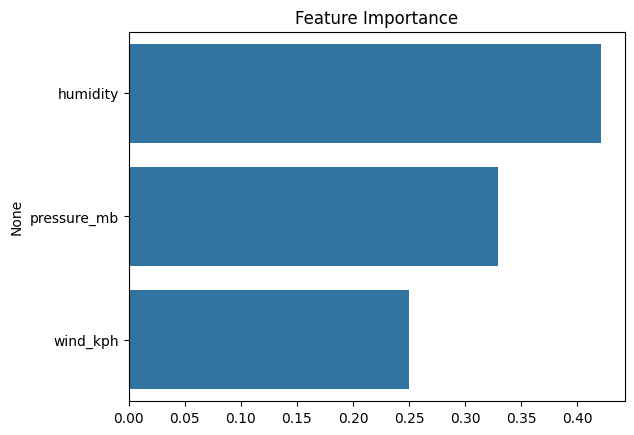

In [25]:
import seaborn as sns

sns.barplot(x=importance, y=features)
plt.title("Feature Importance")
plt.show()


In [29]:
from fpdf import FPDF

pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)

pdf.cell(200, 10, "Weather Trend Forecasting Report", ln=True, align="C")

pdf.multi_cell(0, 10, f"""
- Random Forest: RMSE = {rf_rmse:.2f}, R2 = {rf_r2:.2f}
- Gradient Boosting: RMSE = {gb_rmse:.2f}, R2 = {gb_r2:.2f}
- Ensemble Model: RMSE = {ensemble_rmse:.2f}, R2 = {ensemble_r2:.2f}
""")

pdf.output("Weather_Trend_Forecasting_Report.pdf")


''

In [30]:
importance = rf_model.feature_importances_
features = X.columns

for feature, value in zip(features, importance):
    print(f"{feature}: {value:.2f}")


humidity: 0.42
pressure_mb: 0.33
wind_kph: 0.25


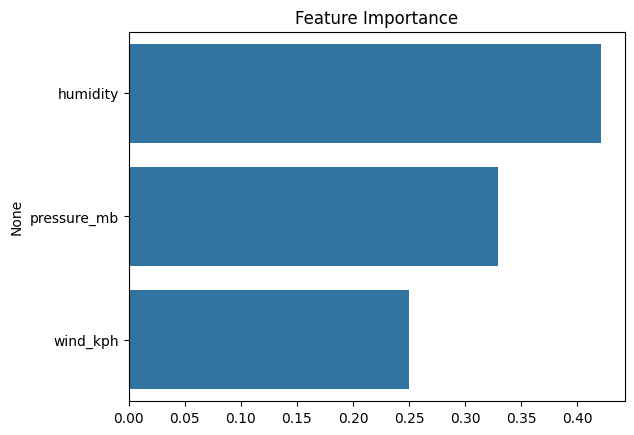

In [31]:
import seaborn as sns

sns.barplot(x=importance, y=features)
plt.title("Feature Importance")
plt.show()


In [32]:
from fpdf import FPDF

pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)

pdf.cell(200, 10, "Weather Trend Forecasting Report", ln=True, align="C")

pdf.multi_cell(0, 10, f"""
- Random Forest: RMSE = {rf_rmse:.2f}, R2 = {rf_r2:.2f}
- Gradient Boosting: RMSE = {gb_rmse:.2f}, R2 = {gb_r2:.2f}
- Ensemble Model: RMSE = {ensemble_rmse:.2f}, R2 = {ensemble_r2:.2f}
""")

pdf.output("Weather_Trend_Forecasting_Report.pdf")


''

In [28]:
!pip install fpdf


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40713 sha256=23bfe8e10eb77dd08777d284465b3a53d62197c7643083ffa3e90543662c793c
  Stored in directory: c:\users\mylav\appdata\local\pip\cache\wheels\6e\62\11\dc73d78e40a218ad52e7451f30166e94491be013a7850b5d75
Successfully built fpdf



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
